In [20]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
from jupyterthemes import jtplot

jtplot.style('grade3', context='poster', fscale=1.5, ticks=True, grid=False)

jtplot.figsize(x=12., y=7., aspect = 1.5)

%matplotlib inline

# Load and preprocess the dataset
---

In [2]:
ls

255fk.jpg       Youtube01-Psy.csv        Youtube04-Eminem.csv
alice_mask.png  Youtube02-KatyPerry.csv  Youtube05-Shakira.csv
__MACOSX/       Youtube03-LMFAO.csv      youtube-comments-spam-detection.ipynb


In [3]:
csvs = ['Youtube01-Psy.csv','Youtube02-KatyPerry.csv','Youtube03-LMFAO.csv','Youtube04-Eminem.csv','Youtube05-Shakira.csv']

dfs = []

for csv in csvs:
    df = pd.read_csv(csv)
    dfs.append(df)

data = pd.concat(dfs)
    

In [4]:
data.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


<br><br> 
** we need only the content and the class **
<br><br>

In [60]:
data = data[['CONTENT','CLASS']]

In [61]:
data.head()

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [125]:
data.CLASS = data.CLASS.map({0:'HAM',1:'SPAM'})

<br>
<br>

** Preprocessing the data **
<br><br>
Let's remove all punctuations & special characters, numerics and keep the words only.
<br><br>

In [126]:
re.findall("[A-Za-z]+","hey 123how are you")

['hey', 'how', 'are', 'you']

<br><br>

In [127]:
def preprocess(text):
    text_cleaned = re.findall('[A-Za-z]+',text.lower())
    return text_cleaned

In [128]:
data['PREPROCESSED'] = data.CONTENT.apply(lambda text: ' '.join(preprocess(text)))

In [129]:
data.head()

,CONTENT,CLASS,PREPROCESSED
0,"Huh, anyway check out this you[tube] channel: ...",SPAM,huh anyway check out this you tube channel kob...
1,Hey guys check out my new channel and our firs...,SPAM,hey guys check out my new channel and our firs...
2,just for test I have to say murdev.com,SPAM,just for test i have to say murdev com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,SPAM,me shaking my sexy ass on my channel enjoy
4,watch?v=vtaRGgvGtWQ Check this out .﻿,SPAM,watch v vtarggvgtwq check this out


<br><br>
** visualize words for spam and ham **
<br><br>

In [130]:
spam_words = reduce(lambda x,y: x+" "+y , data[data.CLASS == 'SPAM'].PREPROCESSED)
ham_words =  reduce(lambda x,y: x+" "+y , data[data.CLASS == 'HAM'].PREPROCESSED)

In [131]:
from collections import Counter

In [132]:
spam_word_freq = Counter(spam_words.split())
ham_word_freq = Counter(ham_words.split())

In [133]:
sw_df= pd.DataFrame(spam_word_freq.most_common(),columns=['word','freq'])
sw_df.head()

,word,freq
0,i,612
1,out,571
2,check,559
3,my,531
4,you,529


In [134]:
hw_df= pd.DataFrame(ham_word_freq.most_common(),columns=['word','freq'])
hw_df.head()

,word,freq
0,i,316
1,this,301
2,the,283
3,song,224
4,is,217


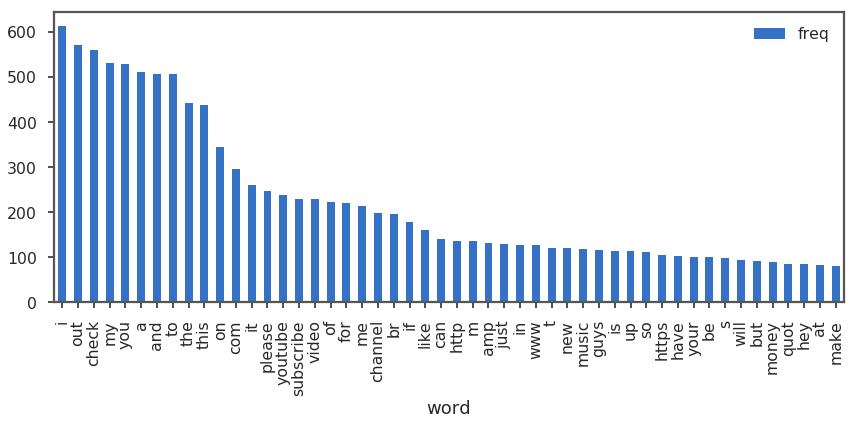

In [135]:
fig, ax = plt.subplots(figsize=(12,6))
sw_df[:50].plot(x='word',y='freq',kind='bar',ax = ax)

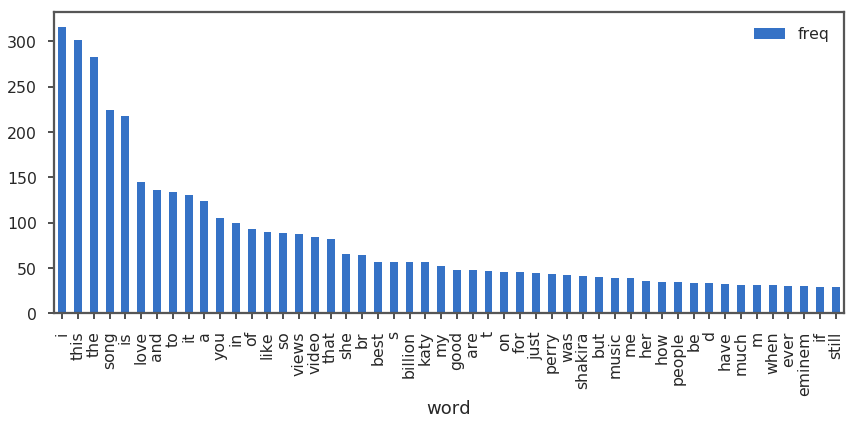

In [136]:
fig, ax = plt.subplots(figsize=(12,6))
hw_df[:50].plot(x='word',y='freq',kind='bar',ax = ax)

<br><br>
Spam/Ham WordCloud
<br><br>

In [137]:
from wordcloud import WordCloud,STOPWORDS
from PIL import Image

In [138]:
alice_mask = np.array(Image.open("alice_mask.png"))

In [139]:
stopwords = set(STOPWORDS)

In [140]:
wc_spam = WordCloud(background_color="white", max_words=2000, mask=alice_mask,
               stopwords=stopwords)

wc_ham = WordCloud(background_color="white", max_words=2000, mask=alice_mask,
               stopwords=stopwords)

In [141]:
wc_spam.generate(spam_words)
wc_ham.generate(ham_words)

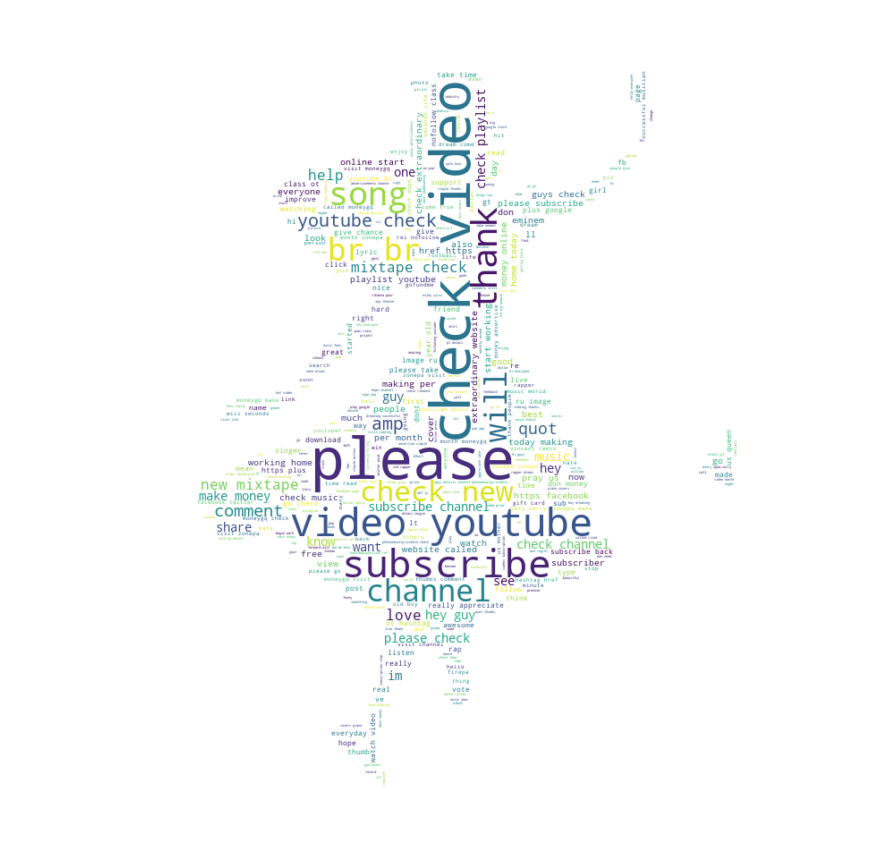

In [142]:
# show
plt.figure(figsize=(15,12))
plt.imshow(wc_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

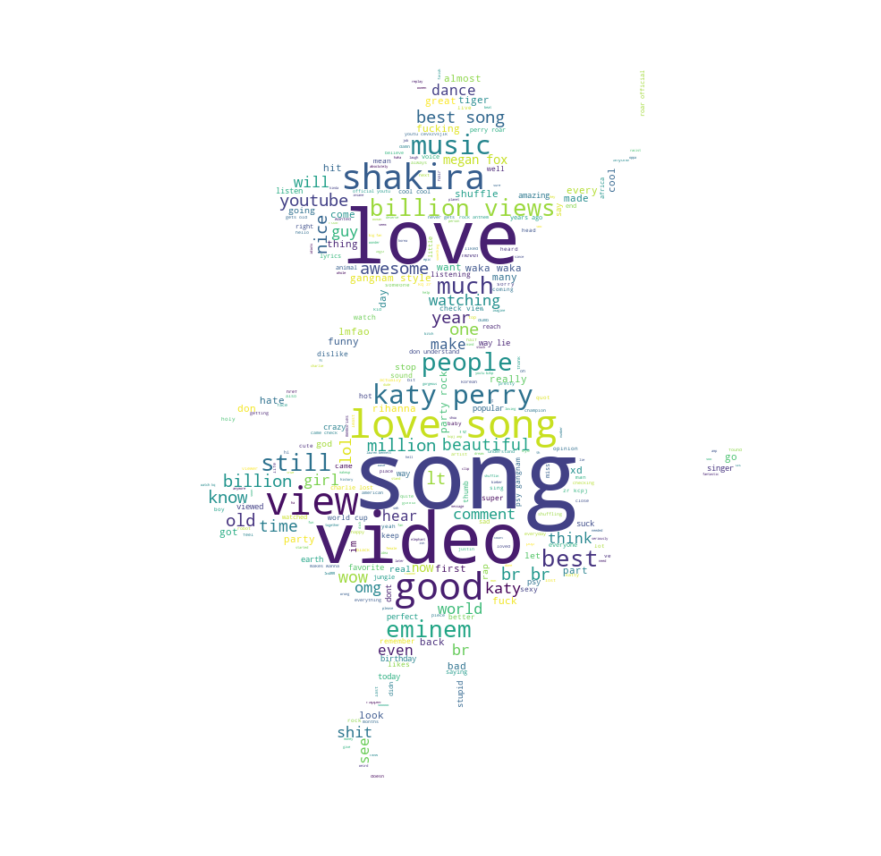

In [143]:
# show
plt.figure(figsize=(15,12))
plt.imshow(wc_ham, interpolation='bilinear')
plt.axis("off")
plt.show()

<br><br>
** Bag of Words Model **
<br><br>

In [162]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,cross_val_score

In [163]:
x_train,x_test,y_train,y_test = train_test_split(data.PREPROCESSED,data.CLASS,test_size=0.1,random_state=2017)

In [164]:
print x_train.shape,y_test.shape

(1760,) (196,)


In [165]:
clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

clf.fit(x_train,y_train)

cvs = cross_val_score(clf,x_train,y_train,cv=10,verbose=0,n_jobs=4)

print "Accuracy: {} +-{} ".format(round(cvs.mean(),2), round(cvs.std(),2))

<br><br>

** plot the confusion matrix **

<br><br>

In [169]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Accent):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


classification report: 
             precision    recall  f1-score   support

        HAM       0.92      0.86      0.89        90
       SPAM       0.88      0.93      0.91       106

avg / total       0.90      0.90      0.90       196

Normalized confusion matrix
[[ 0.85555556  0.14444444]
 [ 0.06603774  0.93396226]]


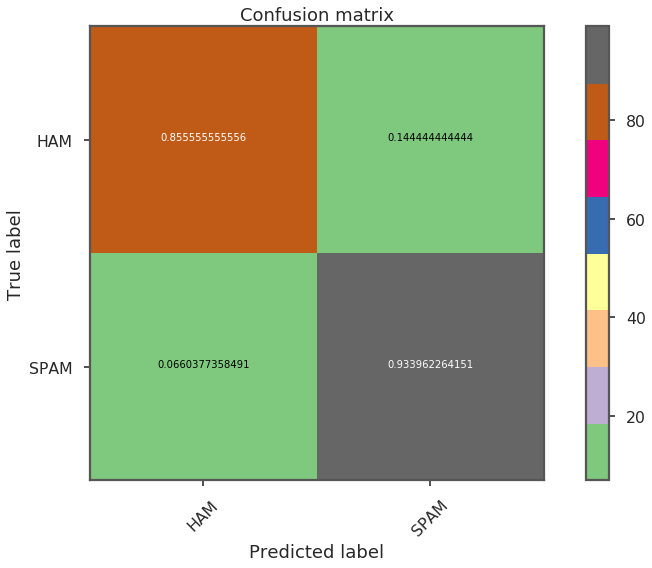

In [171]:
from sklearn.metrics import confusion_matrix,classification_report
y_true = y_test
y_pred = clf.predict(x_test)
print "classification report: "
print classification_report(y_true,y_pred,target_names=clf.classes_)
conf_mat = confusion_matrix(y_true,y_pred)
plot_confusion_matrix(conf_mat,clf.classes_,normalize=True)

<br><br>
Pretty neat eh? Without any optmization we are able to achieve 92% accuracy on cross-validation & 90% accuracy on test set
<br><br>

** Can we do better ? **
<br><br>

In [180]:
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=1000,n_jobs=4,random_state=2017))])

clf.fit(x_train,y_train)

cvs = cross_val_score(clf,x_train,y_train,cv=10,verbose=0,n_jobs=4,scoring='f1_weighted')

print "Accuracy: {} +-{} ".format(round(cvs.mean(),2), round(cvs.std(),2))

Accuracy: 0.96 +-0.01 


classification report: 
             precision    recall  f1-score   support

        HAM       0.95      1.00      0.97        90
       SPAM       1.00      0.95      0.98       106

avg / total       0.98      0.97      0.97       196

Normalized confusion matrix
[[ 1.          0.        ]
 [ 0.04716981  0.95283019]]


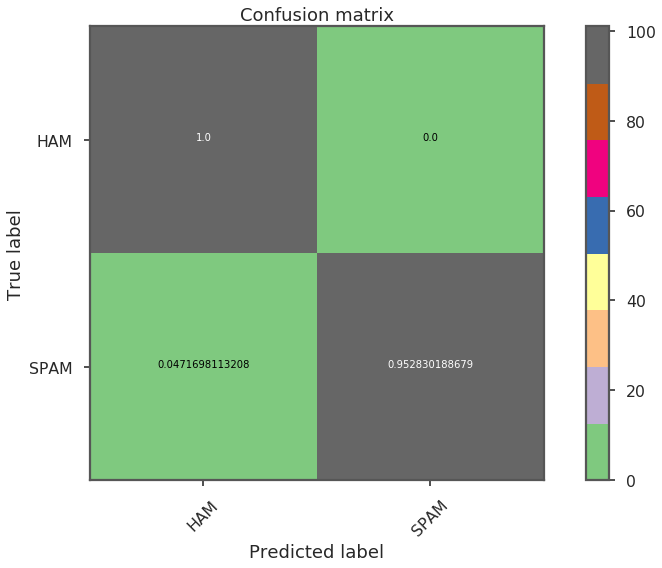

In [181]:
from sklearn.metrics import confusion_matrix,classification_report
y_true = y_test
y_pred = clf.predict(x_test)
print "classification report: "
print classification_report(y_true,y_pred,target_names=clf.classes_)
conf_mat = confusion_matrix(y_true,y_pred)
plot_confusion_matrix(conf_mat,clf.classes_,normalize=True)

<br><br>
wow! we achieved a whopping 96% accuracy on cross-validation and 97% accuracy on the test-set using a Random Forest of 1000 trees
<br> <br>

In [ ]:
We have not removed any stop-words and still achieved great accuracy. An interesting experi